In [1]:
import pandas as pd
import arviz as az
import numpy as np
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='stage', ylabel='q'>

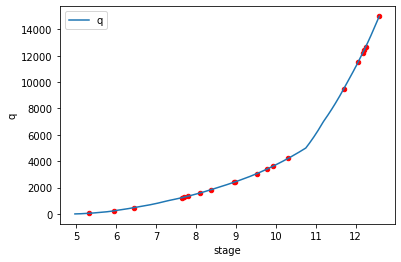

In [2]:
sim_df = pd.read_csv('../data/simulated_rating.csv')
df = sim_df.sample(20)
df = df.sort_values(by='q') #XXX sort or plotting goes crazy
fig, ax = plt.subplots()
sim_df.plot(x='stage',y='q', ax=ax)#, marker='.')
df.plot.scatter(x='stage',y='q', marker='o', color='red', ax=ax)

In [27]:
# this doesn't work for some reason?
#with pm.Model() as test:
#    mu = pm.Normal('mu',0,2, shape=2, transform=tr.sum_to_1, initval=[0.1,0.9])
#    
#mu.eval()

array([-0.58290649, -2.77808417])

In [32]:
#df = pd.read_csv('../data/provo_natural.csv')
#df['log_q'] = np.log(df['q'])
#df['log_s'] = np.log(df['stage'])

#df.plot.scatter("stage","q")

AttributeError: module 'aesara.tensor.math' has no attribute 'inf'

In [35]:
# other priors
# physixal exponents (w)
import pymc as pm
from pymc import Model
from transforms import LogZTransform

import aesara
import aesara.tensor as at

h_obs = df['stage'].values.reshape(-1,1)
    
q_obs = df['q'].values.reshape(-1,1)
q_transform = LogZTransform(q_obs)
y = q_transform.transform(q_obs)


#breaks = np.array([4.0, 11.0])
#breaks_sigma = np.array([2.0, 2.0])
breaks = np.array([4.8, 5.8, 11.0])
breaks_sigma = np.array([0.1, 0.1 , 2.0])

#breaks vi, though setting to other number quickly crashes
#ninf = at.constant([np.NINF])
inf = at.constant([np.inf])
#
#ninf = at.constant([-100.0])
#inf= at.constant([100.0])




clips_array = np.zeros_like(breaks)
clips_array[0] = -ninf.eval()
clips = at.constant(clips_array) # TODO could be a problem with clips?

COORDS = {"obs" : np.arange(len(y)), "splines":np.arange(len(breaks))}
#self.add_coords(COORDS)

with Model(coords=COORDS) as model:

    #TODO CREATE DATA VARIABLE

    
    h0_offset = np.ones_like(breaks)
    h0_offset[0] = 0 #
    
    #PRIORS
    #w = pm.HalfCauchy("w", beta=3, dims="splines")
    w = pm.Normal("w", mu=2.08, sigma=0.3, dims="splines")
    #w = pm.TruncatedNormal("w", mu=2.08, sigma=0.3, lower=0, dims="splines")
    a = pm.Normal("a", mu=0, sigma=10)
    hs = pm.Normal("hs", mu=breaks, sigma=breaks_sigma, dims="splines") #shape=breaks.shape[0])
    
    #hs = pm.Exponential("hs", breaks, dims="splines")
    

    hsi = at.concatenate([hs, inf])[1:]
    
    
    # MODEL
    h0 = hs - h0_offset #XXX check this. should it be a tensor?
    #h = at.dcol('h')

    b0 = at.switch( at.le(h_obs, hs), clips , at.log(h_obs-h0))
    #b1 = at.switch( at.le(h_obs, hsi), b0, at.log(hsi-h0))
    b1 = pm.Deterministic("b1", at.switch( at.le(h_obs, hsi), b0, at.log(hsi-h0)) )
    #b0 = at.switch( at.le(h, hs), clips , at.log(h-hs))
    #b1 = at.switch( at.le(h, hsi), b0, at.log(hsi-hs))
    #B = aesara.function([h], b1) #b1
    
    mu = pm.Deterministic("mu", a + at.dot(b1, w.T))
    sigma = pm.HalfCauchy("sigma", beta=1, initval=0.01)
    D = pm.Normal("D", mu, sigma, observed=y.flatten(), dims="obs") #TODO check flatten

AttributeError: module 'aesara.tensor' has no attribute 'inf'

In [36]:
n=4
with model:
    trace = pm.sample(tune=2000, chains=n, cores=n, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/thodson/.local/miniconda3/envs/pymc/lib/python3.7/site-packages/pymc/aesaraf.py:1010: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  **kwargs,
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, a, hs, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 51 seconds.


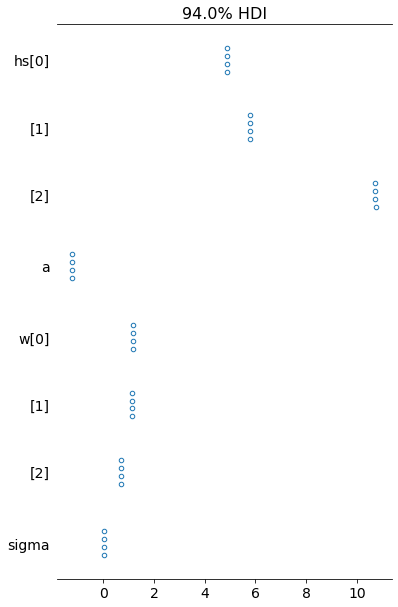

In [37]:
import arviz as az

az.plot_forest(trace, var_names=["hs","a","w","sigma"], combined=False);

In [34]:
az.summary(trace, var_names=["w","a","sigma","hs"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],1.182,0.039,1.113,1.258,0.001,0.001,1336.0,1357.0,1.0
w[1],1.151,0.012,1.128,1.175,0.000,0.000,1440.0,1860.0,1.0
w[2],0.682,0.006,0.671,0.694,0.000,0.000,2331.0,2240.0,1.0
a,-1.213,0.011,-1.235,-1.195,0.000,0.000,1645.0,1824.0,1.0
sigma,0.014,0.001,0.012,0.015,0.000,0.000,3009.0,2792.0,1.0
hs[0],4.891,0.013,4.867,4.915,0.000,0.000,1336.0,1549.0,1.0
hs[1],5.804,0.023,5.759,5.846,0.001,0.000,1411.0,1973.0,1.0
hs[2],10.734,0.016,10.704,10.764,0.000,0.000,2577.0,2661.0,1.0


In [242]:
az.summary(trace, var_names=["w","a","sigma","hs"])

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],1.234,0.045,1.155,1.318,0.003,0.002,310.0,462.0,NaN
w[1],1.159,0.012,1.133,1.180,0.001,0.000,368.0,484.0,NaN
w[2],0.699,0.005,0.689,0.708,0.000,0.000,662.0,564.0,NaN
a,-1.402,0.012,-1.428,-1.382,0.001,0.000,446.0,235.0,NaN
sigma,0.014,0.001,0.012,0.016,0.000,0.000,781.0,331.0,NaN
hs[0],4.882,0.014,4.856,4.908,0.001,0.001,312.0,452.0,NaN
hs[1],5.811,0.025,5.768,5.862,0.001,0.001,356.0,425.0,NaN
hs[2],10.697,0.018,10.660,10.734,0.001,0.001,576.0,679.0,NaN


In [260]:
model.point_logps()

{'w': 0.86, 'a': -3.22, 'hs': -2.25, 'sigma': -5.06, 'D': -4350092.66}

In [261]:
model.initial_point

{'w': array([2.08, 2.08, 2.08]),
 'a': array(0.),
 'hs': array([ 4.8,  5.8, 11. ]),
 'sigma_log__': array(-4.60517019)}

In [262]:
b1.eval()

array([[-1.61055683e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.14013346e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.07946770e+00,  0.00000000e+00,  0.00000000e+00],
       [-6.54356673e-01,  0.00000000e+00,  0.00000000e+00],
       [-6.16600408e-01,  0.00000000e+00,  0.00000000e+00],
       [-5.62511379e-01,  0.00000000e+00,  0.00000000e+00],
       [-5.11198458e-01,  0.00000000e+00,  0.00000000e+00],
       [-3.15017174e-01,  0.00000000e+00,  0.00000000e+00],
       [-2.74731177e-01,  0.00000000e+00,  0.00000000e+00],
       [ 2.12555643e-01,  6.10399788e-02,  0.00000000e+00],
       [ 2.12555643e-01,  7.04038568e-02,  0.00000000e+00],
       [ 2.12555643e-01,  1.24817267e-01,  0.00000000e+00],
       [ 2.12555643e-01,  2.64624331e-01,  0.00000000e+00],
       [ 2.12555643e-01,  2.79857597e-01,  0.00000000e+00],
       [ 2.12555643e-01,  3.38571039e-01,  0.00000000e+00],
       [ 2.12555643e-01,  3.52726144e-01,  0.00000000e+00],
       [ 2.12555643e-01,  4.78059474e-01

In [249]:
model.up

['D',
 'RV_dims',
 '_RV_dims',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_aesara_config',
 '_config_context',
 '_context_class',
 '_coords',
 '_dim_lengths',
 '_initial_values',
 '_parent',
 '_repr_latex_',
 '_validate_name',
 'a',
 'add_coord',
 'add_coords',
 'add_random_variable',
 'auto_deterministics',
 'basic_RVs',
 'check_bounds',
 'check_start_vals',
 'check_test_point',
 'compile_d2logp',
 'compile_dlogp',
 'compile_fn',
 'compile_logp',
 'compute_initial_point',
 'cont_vars',
 'contexts',
 'coords',
 'create_value_var',
 'd2logpt',
 'datalogpt',
 'deterministics',
 'dim_length

In [239]:
with model:
    mean_field = pm.fit(method="advi", n=30_000)

FloatingPointError: NaN occurred in optimization. 
The current approximation of RV `sigma_log__`.ravel()[0] is NaN.
The current approximation of RV `hs`.ravel()[0] is NaN.
The current approximation of RV `hs`.ravel()[1] is NaN.
The current approximation of RV `hs`.ravel()[2] is NaN.
The current approximation of RV `w`.ravel()[0] is NaN.
The current approximation of RV `w`.ravel()[1] is NaN.
The current approximation of RV `w`.ravel()[2] is NaN.
The current approximation of RV `a`.ravel()[0] is NaN.
Try tracking this parameter: http://docs.pymc.io/notebooks/variational_api_quickstart.html#Tracking-parameters

In [ ]:
vi_trace = mean_field.sample(5000)

In [111]:
## other priors
# physixal exponents (w)
import pymc as pm
from pymc import Model
from transforms import LogZTransform

import aesara
import aesara.tensor as at

h_obs = df['stage'].values.reshape(-1,1)
    
q_obs = df['q'].values.reshape(-1,1)
q_transform = LogZTransform(q_obs)
y = q_transform.transform(q_obs)


#breaks = np.array([4.0, 11.0])
#breaks_sigma = np.array([2.0, 2.0])
segments = 3

#ninf = at.constant([np.NINF])
#inf = at.constant([np.inf])
ninf = at.constant([-999.0])
inf = at.constant([999.0])

clips_array = np.zeros(segments)
clips_array[0] = np.NINF
clips = at.constant(clips_array) # TODO could be a problem with clips?

COORDS = {"obs" : np.arange(len(y)), "splines":np.arange(segments)}
#self.add_coords(COORDS)

with Model(coords=COORDS) as model:
    #import pdb; pdb.set_trace()

    #TODO CREATE DATA VARIABLE

    
    h0_offset = np.ones(segments)
    h0_offset[0] = 0 #
    
    #PRIORS
    #w = pm.HalfCauchy("w", beta=3, dims="splines")
    w = pm.Normal("w", mu=2.08, sigma=0.3, dims="splines")
    #w = pm.TruncatedNormal("w", mu=2.08, sigma=0.3, lower=0, dims="splines")
    a = pm.Normal("a", mu=0, sigma=10)
    
    if segments == 1:
        hs = pm.Normal("hs", mu=0, sigma=3, shape=1)
        
    else:
        hss = pm.Normal("hss", mu=0, sigma=3, shape=1)
        # uniformly distribute the rest between hss
        intervals = pm.HalfCauchy("ints", beta=3, shape=segments-1)
        #intervals = pm.Exponential("ints", 3, shape=segments-1)
        #intervals = pm.Uniform("ints", lower=0.0, upper=10.0, shape=segments-1, initval=[1.0,1.0])
        temp = at.concatenate([hss, intervals])
        hs = pm.Deterministic("hs", temp.cumsum()) 
    
    
    
    #hs = pm.Normal("hs", mu=breaks, sigma=breaks_sigma, dims="splines") #shape=breaks.shape[0])
    
    #hs = pm.Exponential("hs", breaks, dims="splines")
    

    hsi = at.concatenate([hs, inf])[1:]
    
    
    # MODEL
    h0 = hs - h0_offset #XXX check this. should it be a tensor?
    #h = at.dcol('h')

    b0 = at.switch( at.le(h_obs, hs), clips , at.log(h_obs-h0))
    b1 = at.switch( at.le(h_obs, hsi), b0, at.log(hsi-h0))
    #b0 = at.switch( at.le(h, hs), clips , at.log(h-hs))
    #b1 = at.switch( at.le(h, hsi), b0, at.log(hsi-hs))
    #B = aesara.function([h], b1) #b1
    
    mu = pm.Deterministic("mu", a + at.dot(b1, w.T))
    sigma = pm.HalfCauchy("sigma", beta=1, initval=0.01)
    D = pm.Normal("D", mu, sigma, observed=y.flatten(), dims="obs") #TODO check flatten

In [112]:
h0.eval()

array([1.78001092, 3.56351224, 3.60433736])

In [113]:
# CompileD XXXX
with model:
    trace = pm.sample(tune=2000, chains=1, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/thodson/.local/miniconda3/envs/pymc/lib/python3.7/site-packages/pymc/aesaraf.py:1010: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  **kwargs,
Sequential sampling (1 chains in 1 job)
NUTS: [w, a, hss, ints, sigma]


Sampling 1 chain for 2_000 tune and 1_000 draw iterations (2_000 + 1_000 draws total) took 182 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [115]:
az.summary(trace, var_names=["w","a","sigma","hs"])

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],2.156,0.275,1.587,2.634,0.010,0.007,695.0,721.0,NaN
w[1],2.187,0.319,1.615,2.801,0.011,0.008,879.0,676.0,NaN
w[2],1.433,0.031,1.378,1.492,0.001,0.001,825.0,811.0,NaN
a,-1.322,0.288,-1.862,-0.787,0.013,0.009,505.0,483.0,NaN
sigma,0.084,0.006,0.074,0.095,0.000,0.000,823.0,695.0,NaN
hs[0],4.628,0.103,4.430,4.819,0.005,0.003,511.0,508.0,NaN
hs[1],5.394,0.060,5.272,5.500,0.002,0.002,734.0,793.0,NaN
hs[2],5.478,0.047,5.390,5.560,0.002,0.001,776.0,762.0,NaN


In [193]:
### BEST YET!
## other priors
# physixal exponents (w)
import pymc as pm
from pymc import Model
from transforms import LogZTransform

import aesara
import aesara.tensor as at

h_obs = df['stage'].values.reshape(-1,1)
    
q_obs = df['q'].values.reshape(-1,1)
q_transform = LogZTransform(q_obs)
y = q_transform.transform(q_obs)



segments = 3

#ninf = at.constant([np.NINF])
#inf = at.constant([np.inf])
ninf = at.constant([-10.0])
inf = at.constant([10.0])

clips_array = np.zeros(segments)
clips_array[0] = ninf.eval()
clips = at.constant(clips_array) # TODO could be a problem with clips?

COORDS = {"obs" : np.arange(len(y)), "splines":np.arange(segments)}
#self.add_coords(COORDS)

with Model(coords=COORDS) as model:

    h0_offset = np.ones(segments)
    h0_offset[0] = 0 #
    
    #PRIORS
    w = pm.Normal("w", mu=2.08, sigma=0.3, dims="splines")
    #w = pm.TruncatedNormal("w", mu=2.08, sigma=0.3, lower=0, dims="splines")
    a = pm.Normal("a", mu=0, sigma=10)
    sigma = pm.HalfCauchy("sigma", beta=1, initval=0.01)
    
    intervals = pm.HalfCauchy("intervals", beta=3, shape=segments)
    hs = pm.Deterministic("hs", intervals.cumsum())
    
    hsi = at.concatenate([hs, inf])[1:]
    
    
    # MODEL
    h0 = hs - h0_offset 
    b0 = at.switch( at.le(h_obs, hs), clips , at.log(h_obs-h0))
    b1 = at.switch( at.le(h_obs, hsi), b0, at.log(hsi-h0))
    mu = pm.Deterministic("mu", a + at.dot(b1, w.T))
    
    D = pm.Normal("D", mu, sigma, observed=y.flatten(), dims="obs") #TODO check flatten

In [194]:
#with model:
#    mean_field = pm.fit(method="advi", n=30_000)

In [195]:
# CompileD XXXX
# set inf to 10
# inf is hs so could be higher
# ninf is y so -10 may be fine
with model:
    trace = pm.sample(tune=2000, chains=1, target_accept=0.90) #2 minutes before

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/thodson/.local/miniconda3/envs/pymc/lib/python3.7/site-packages/pymc/aesaraf.py:1010: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  **kwargs,
Sequential sampling (1 chains in 1 job)
NUTS: [w, a, intervals, sigma]


Sampling 1 chain for 2_000 tune and 1_000 draw iterations (2_000 + 1_000 draws total) took 324 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [198]:
az.summary(trace, var_names=["w","a","sigma","hs"])

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],2.107,0.301,1.588,2.693,0.020,0.015,244.0,540.0,NaN
w[1],2.111,0.296,1.550,2.638,0.020,0.014,215.0,262.0,NaN
w[2],1.866,0.153,1.589,2.155,0.010,0.007,215.0,203.0,NaN
a,-4.587,1.768,-6.902,-0.559,0.179,0.127,148.0,109.0,NaN
sigma,0.217,0.016,0.186,0.246,0.001,0.001,458.0,379.0,NaN
hs[0],1.943,1.275,0.002,4.323,0.138,0.121,86.0,29.0,NaN
hs[1],3.693,1.216,1.539,5.298,0.081,0.063,118.0,46.0,NaN
hs[2],5.103,0.219,4.683,5.532,0.014,0.010,220.0,158.0,NaN


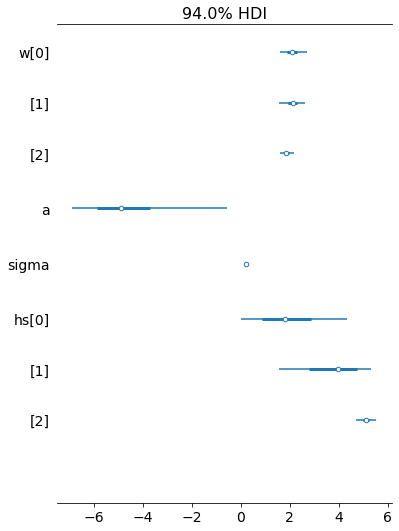

In [199]:
az.plot_forest(trace, var_names=["w","a","sigma", "hs","sigma"], combined=False);

In [200]:
with model:
    mean_field = pm.fit(method="advi", n=30_000)

/home/thodson/.local/miniconda3/envs/pymc/lib/python3.7/site-packages/pymc/aesaraf.py:1010: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  **kwargs,


FloatingPointError: NaN occurred in optimization. 
The current approximation of RV `a`.ravel()[0] is NaN.
The current approximation of RV `intervals_log__`.ravel()[0] is NaN.
The current approximation of RV `intervals_log__`.ravel()[1] is NaN.
The current approximation of RV `intervals_log__`.ravel()[2] is NaN.
The current approximation of RV `w`.ravel()[0] is NaN.
The current approximation of RV `w`.ravel()[1] is NaN.
The current approximation of RV `w`.ravel()[2] is NaN.
The current approximation of RV `sigma_log__`.ravel()[0] is NaN.
Try tracking this parameter: http://docs.pymc.io/notebooks/variational_api_quickstart.html#Tracking-parameters

In [ ]:
vi_trace = mean_field.sample(5000)

In [ ]:
az.summary(vi_trace, var_names=["w","a","sigma","hs"])

In [ ]:
def pairplot_divergence(trace, ax=None, divergence=True, color="C3", divergence_color="C2"):
    theta = trace.get_values(varname="theta", combine=True)[:, 0]
    logtau = trace.get_values(varname="tau_log__", combine=True)
    if not ax:
        _, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(theta, logtau, "o", color=color, alpha=0.5)
    if divergence:
        divergent = trace["diverging"]
        ax.plot(theta[divergent], logtau[divergent], "o", color=divergence_color)
    ax.set_xlabel("theta[0]")
    ax.set_ylabel("log(tau)")
    ax.set_title("scatter plot between log(tau) and theta[0]")
    return ax


pairplot_divergence(short_trace);

In [11]:
with model:
    mean_field = pm.fit(method="advi", n=30_000)

/home/thodson/.local/miniconda3/envs/pymc/lib/python3.7/site-packages/pymc/aesaraf.py:1010: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  **kwargs,


FloatingPointError: NaN occurred in optimization. 
The current approximation of RV `sigma_log__`.ravel()[0] is NaN.
The current approximation of RV `w`.ravel()[0] is NaN.
The current approximation of RV `w`.ravel()[1] is NaN.
The current approximation of RV `ints_log__`.ravel()[0] is NaN.
The current approximation of RV `a`.ravel()[0] is NaN.
The current approximation of RV `hss`.ravel()[0] is NaN.
Try tracking this parameter: http://docs.pymc.io/notebooks/variational_api_quickstart.html#Tracking-parameters

In [19]:
vi_trace = mean_field.sample(5000)


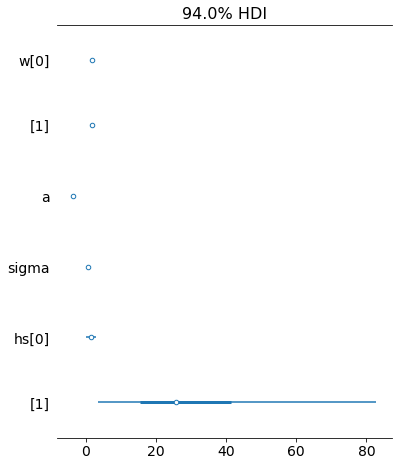

In [22]:
az.plot_forest(vi_trace, var_names=["w","a","sigma", "hs"], combined=False);

In [25]:
az.summary(vi_trace, var_names=["w","a","sigma", "hs"])

arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],1.785,0.094,1.602,1.947,0.001,0.001,4788.0,4846.0,NaN
w[1],1.911,0.313,1.346,2.500,0.004,0.003,4917.0,4527.0,NaN
a,-3.509,0.214,-3.893,-3.094,0.003,0.002,4863.0,4452.0,NaN
sigma,0.673,0.131,0.450,0.924,0.002,0.001,4810.0,4561.0,NaN
hs[0],1.541,0.820,0.023,3.076,0.012,0.008,4840.0,4795.0,NaN
hs[1],34.150,31.218,3.624,82.823,0.460,0.325,4891.0,4621.0,NaN


In [26]:
# CompileD XXXX
with model:
    trace = pm.sample(tune=2000, chains=1, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/thodson/.local/miniconda3/envs/pymc/lib/python3.7/site-packages/pymc/aesaraf.py:1010: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  **kwargs,
Sequential sampling (1 chains in 1 job)
NUTS: [w, a, hss, ints, sigma]


Sampling 1 chain for 2_000 tune and 1_000 draw iterations (2_000 + 1_000 draws total) took 151 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


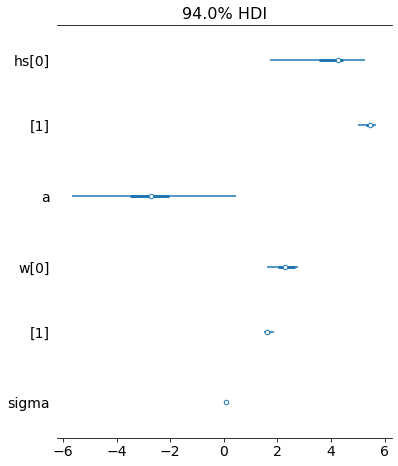

In [24]:
import arviz as az

az.plot_forest(trace, var_names=["hs","a","w","sigma"], combined=False);

In [3]:
#https://github.com/aesara-devs/aesara